In [2]:
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import ADASYN
from sklearn.decomposition import PCA

In [3]:
from IPython.display import Audio

# create a PING noise to let you know modeling is done
sound_file = 'glass_ping-Go445-1207030150.mp3'
play_sound = Audio(sound_file, autoplay=True)

## Cleaning

https://www.kaggle.com/c/ieee-fraud-detection/overview

In [4]:
train_df = pd.read_csv('Fraud/train_transaction.csv')

# test is based on Kaggle competition, and does not include targets
test_df = pd.read_csv('Fraud/test_transaction.csv')

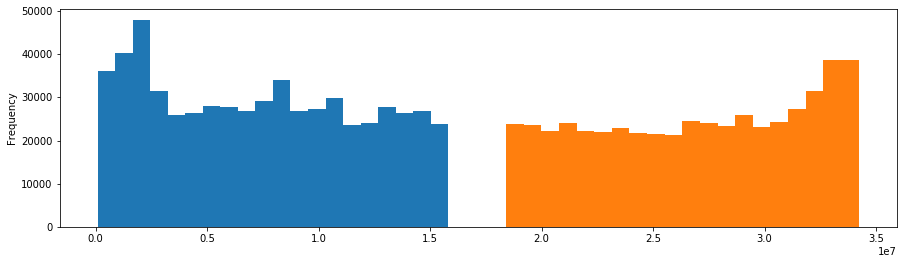

In [5]:
train_df['TransactionDT'].plot(kind='hist', bins=20, figsize=(15,4))
test_df['TransactionDT'].plot(kind='hist', bins=20, figsize=(15,4));

In [6]:
total_trans = train_df['TransactionAmt'].sum()

fraud_trans = train_df.query("isFraud == 1")['TransactionAmt'].sum()

print(f'Total transaction amount: ${round(total_trans,2)}')
print(f'Total fraud transaction amount: ${round(fraud_trans,2)}')
print(f'Fraud represents {round((fraud_trans/total_trans)*100,2)}% of total.')

Total transaction amount: $79738948.74
Total fraud transaction amount: $3083844.86
Fraud represents 3.87% of total.


In [7]:
## un-comment if you'd like to reduce the memory usage - 
## potentially breaks some functions later

# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df


# train_df = reduce_mem_usage(train_df)
# test_df = reduce_mem_usage(test_df)

# play_sound

In [8]:
# test_df does not contain targets, and only used for Kaggle competition
del test_df

In [9]:
train_df = train_df.iloc[:, :32].drop(columns=['dist1','dist2','R_emaildomain'])

In [10]:
# find catagorical columns
cat_cal = [x for x in train_df if train_df[x].dtype == 'O']

# dummy features
dummy_df = pd.get_dummies(train_df, columns=cat_cal, drop_first=True)

dummy_df.sample(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
355303,3342303,0,8796239,171.0,2157,111.0,150.0,226.0,494.0,87.0,...,0,0,0,0,1,0,0,0,0,0
194819,3181819,0,4388390,272.0,16297,544.0,150.0,117.0,123.0,87.0,...,0,0,0,0,1,0,0,0,0,0


## Setting Features and Target

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = dummy_df.drop(columns=['isFraud'])
y = dummy_df['isFraud']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Replacing NA Values

In [14]:
# show % of NAs in columns
(train_df.isna().sum() / train_df.shape[0]) * 100

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
P_emaildomain     15.994852
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.214888
dtype: float64

In [16]:
%%time
# find the transactions that have at least one na
na_lst = []
for i in train_df.index:
    if train_df.iloc[i].isnull().any() > 0:
        na_lst.append(i)
        
len(na_lst)

CPU times: user 3min 4s, sys: 1.9 s, total: 3min 6s
Wall time: 3min 5s


167282

##### Because there are so many observations with NAs, we're going to impute those values, instead of dropping them

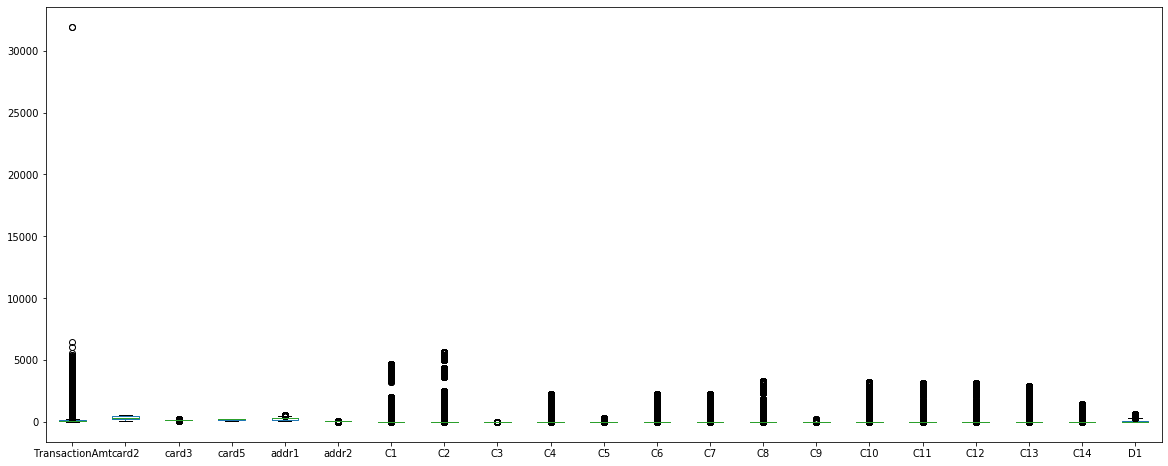

In [15]:
# lots of outliers
train_df.iloc[: ,3:].drop(columns=['card1']).plot(kind='box', figsize=(20,8));

In [16]:
na_cols = X_train.columns[X_train.isna().sum()>0]

test_na_cols = X_test.columns[X_test.isna().sum()>0]

card2 mean 362.44545010625933
card2 median 361.0


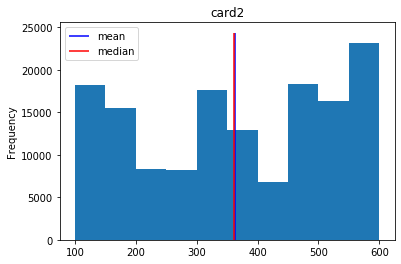

card3 mean 153.1657112973553
card3 median 150.0


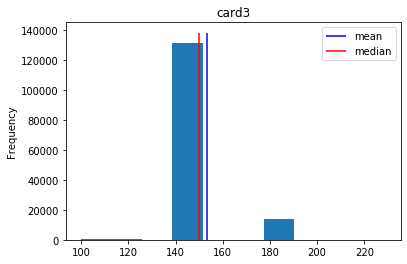

card5 mean 199.17866353724602
card5 median 226.0


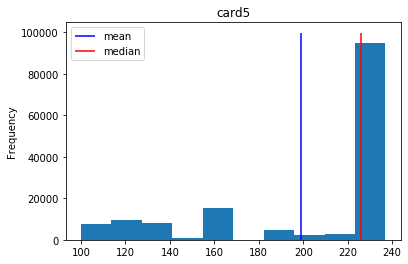

addr1 mean 290.51643775124865
addr1 median 299.0


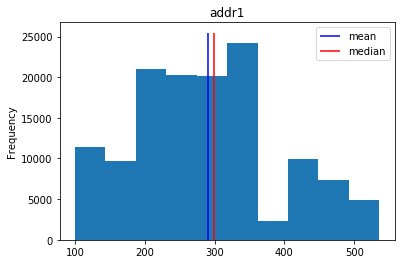

addr2 mean 86.8081830917286
addr2 median 87.0


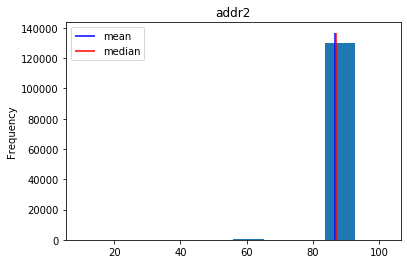

D1 mean 94.72293899269053
D1 median 3.0


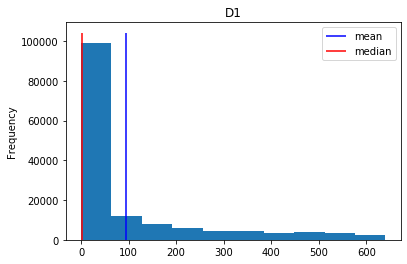

In [17]:
# showing the best values of dataset to replace NAs with

for col in X_test[na_cols]:
    if X_test[col].dtype != 'O':
        X_test[col].plot(kind='hist', label='')
        plt.title(col)
        ymin, ymax = plt.ylim()
        plt.vlines(X_test[col].mean(), ymin, ymax, color='blue', label='mean')
        plt.vlines(X_test[col].median(), ymin, ymax, color='red', label='median')
        print(f'{col} mean {X_test[col].mean()}')
        print(f'{col} median {X_test[col].median()}')
        plt.legend()
        plt.show()

In [18]:
# fill NAs with median values
for column in X_train[na_cols]:
    median = X_train[column].median()
    X_train[column].fillna(median, inplace=True)
    

for column in X_train[test_na_cols]:
    median = X_test[column].median()
    X_test[column].fillna(median, inplace=True)

X_test.isna().sum().sum()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

## ADASYN Over Sampling

In [19]:
ada = ADASYN('minority', random_state=42, n_neighbors = 6, n_jobs=-1)

columns= X_train.columns
X_train, y_train = ada.fit_resample(X_train, y_train)

y_train = pd.Series(y_train)
X_train = pd.DataFrame(X_train, columns=columns)
X_train.shape, y_train.shape

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((857945, 92), (857945,))

In [21]:
X_train.to_pickle('X_train')
y_train.to_pickle('y_train')
X_test.to_pickle('X_test')
y_test.to_pickle('y_test')